In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#cargamos los datos
metadata = pd.read_feather('metadata.feather')
reviews = pd.read_feather('reviews.feather')

In [4]:
metadata.head(2)

,name,gmap_id,latitude,longitude,category,avg_rating,num_of_reviews
0,Dunkin',0x89c261f60bdf13db:0x38da730e4687a97b,40.763985,-73.771430,"[Coffee shop, Bagel shop, Bakery, Breakfast re...",3.5,8
1,李小龍台吃,0x89c289efdb82221b:0xed627c2af97c2069,40.770059,-73.735522,[Restaurant],4.0,27


In [5]:
reviews.head(2)

,user_id,name,rating,gmap_id
0,1.018635e+20,Maria Patricia Londoño,4,0x89c261f60bdf13db:0x38da730e4687a97b
1,1.019546e+20,Kristal,5,0x89c261f60bdf13db:0x38da730e4687a97b


## Analisis exploratorio de los datos.
Es importante que tengamos una idea de como distribuyen nuestros datos para poder tener ciertas expectativas de nuestro modelo. Tambien esta distribucion podra ayudarnos a explicar ciertos fenomenos.

### 1. Distribucion del rating promedio por restaurante.

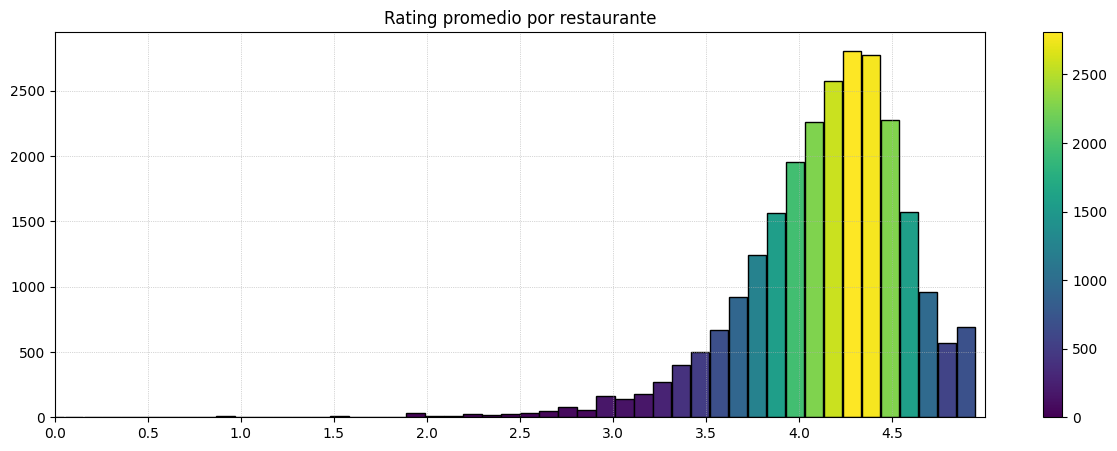

In [6]:
bin_edges = np.linspace(0, 5, 50)

hist, bin_edges = np.histogram(metadata['avg_rating'], bins=bin_edges)
colormap = plt.cm.viridis
norm = plt.Normalize(hist.min(), hist.max())
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

plt.figure(figsize=(15, 5))
bars = plt.bar(bin_edges[:-1], hist, width=0.1, color=colormap(norm(hist)), edgecolor='black')
plt.colorbar(sm)
plt.xlim(0, 5)
plt.xticks(np.arange(0, 5, 0.5))
plt.grid(True, linestyle=':', linewidth=0.5)
plt.title('Rating promedio por restaurante')
plt.show()

### 2. Cantidad de reviews por rating o rating por review.

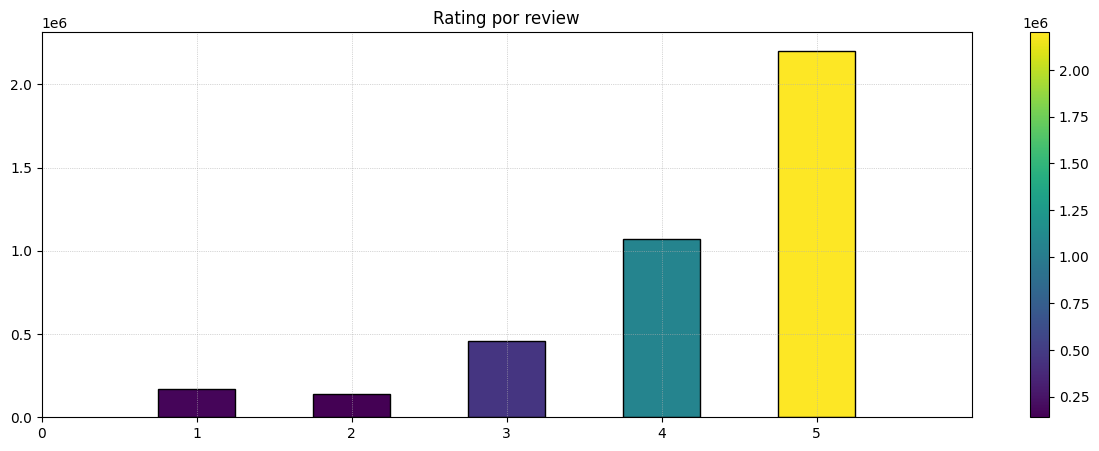

In [7]:
bin_edges = np.linspace(1, 6, 6)

hist, bin_edges = np.histogram(reviews['rating'], bins=bin_edges)
colormap = plt.cm.viridis
norm = plt.Normalize(hist.min(), hist.max())
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)


plt.figure(figsize=(15, 5))
bars = plt.bar(bin_edges[:-1], hist, width=0.5, color=colormap(norm(hist)), edgecolor='black')
plt.colorbar(sm)
plt.xlim(0, 6)
plt.xticks(np.arange(0, 6))
plt.grid(True, linestyle=':', linewidth=0.5)
plt.title('Rating por review')
plt.show()

### 3. Distribucion de la cantidad de reviews por usuario.

In [8]:
#hay que juntar cuantas reviews tiene cada usuario
reviews_por_usuario = reviews.groupby('user_id').size()

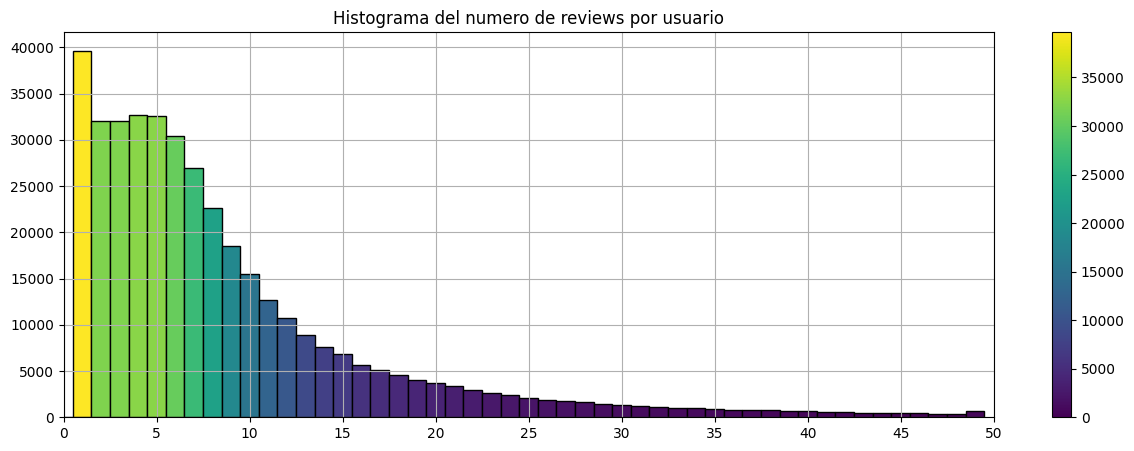

In [9]:
bin_edges = np.linspace(0, 50, 51)

hist, bin_edges = np.histogram(reviews_por_usuario, bins=bin_edges)
colormap = plt.cm.viridis
norm = plt.Normalize(hist.min(), hist.max())
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)

plt.figure(figsize=(15, 5))
bars = plt.bar(bin_edges[:-1], hist, width=1, color=colormap(norm(hist)), edgecolor='black')
plt.colorbar(sm)
plt.title('Histograma del numero de reviews por usuario')
plt.xlim(0, 50)
plt.xticks(range(0, 51, 5))
plt.grid(True)
plt.show()

### 4. Distribucion de rating bayesiano por restaurante.

El rating bayesiano considera la cantidad de reviews y la distribucion original de los ratings por restaurante, asi podemos tener una idea de ratings mas "reales".

In [10]:
def bayesian_rating(row, C, m):
    R = row['avg_rating']
    v = row['num_of_reviews']
    return (v / (v + m)) * R + (m / (v + m)) * C

In [11]:
C = metadata['avg_rating'].mean()
m = metadata['num_of_reviews'].quantile(0.5) # Valor umbral, mediana de las reviews

metadata['rating_bayesiano'] = metadata.apply(bayesian_rating, C=C, m=m, axis=1)
top_20_bayesiano = metadata.sort_values(by='rating_bayesiano', ascending=False).head(20)

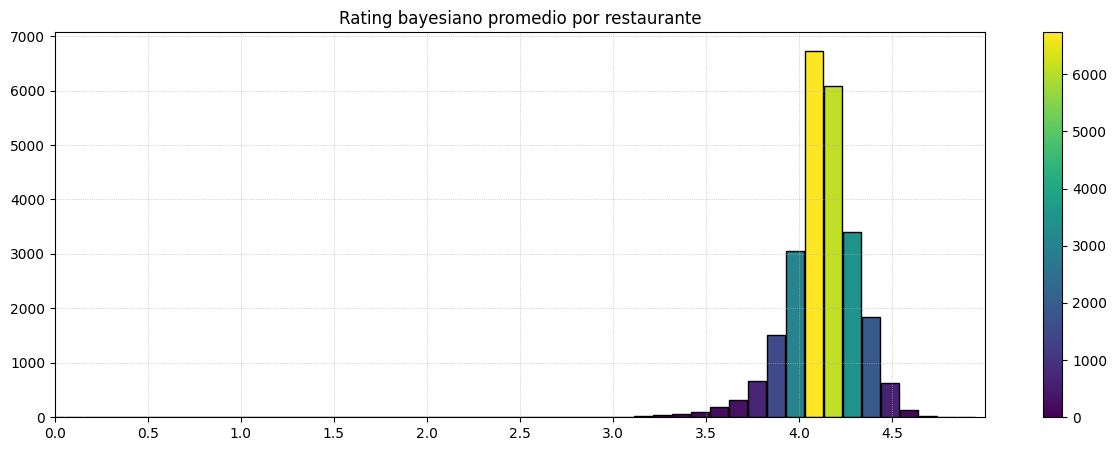

In [12]:
bin_edges = np.linspace(0, 5, 50)

hist, bin_edges = np.histogram(metadata['rating_bayesiano'], bins=bin_edges)
colormap = plt.cm.viridis
norm = plt.Normalize(hist.min(), hist.max())
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)


plt.figure(figsize=(15, 5))
bars = plt.bar(bin_edges[:-1], hist, width=0.1, color=colormap(norm(hist)), edgecolor='black')
plt.colorbar(sm)
plt.xlim(0, 5)
plt.xticks(np.arange(0, 5, 0.5))
plt.grid(True, linestyle=':', linewidth=0.5)
plt.title('Rating bayesiano promedio por restaurante')
plt.show()

### 5. Tabla resumen.

In [13]:
cant_restaurantes = len(metadata)
cant_reviews = len(reviews)
cant_usuarios = reviews['user_id'].nunique()

promedio_review_usuario = round(reviews_por_usuario.mean(), 5)
ds_review_usuario = round(reviews_por_usuario.std(), 5)
promedio_review_restaurante = round(metadata['num_of_reviews'].mean(), 5)
ds_review_restaurante = round(metadata['num_of_reviews'].std(), 5)
promedio_rating_restaurante = round(metadata['avg_rating'].mean(), 5)
ds_rating_restaurante = round(metadata['avg_rating'].std(), 5)

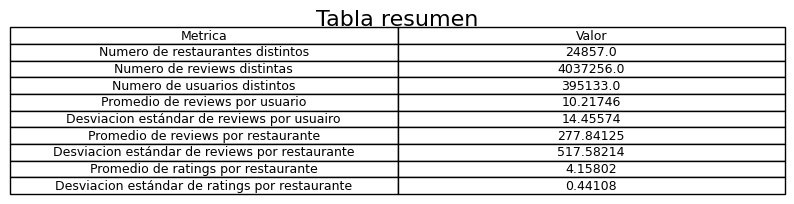

In [14]:
metricas = {
    'Metrica': ['Numero de restaurantes distintos', 'Numero de reviews distintas', 'Numero de usuarios distintos',
                'Promedio de reviews por usuario', 'Desviacion estándar de reviews por usuairo',
                'Promedio de reviews por restaurante', 'Desviacion estándar de reviews por restaurante',
                'Promedio de ratings por restaurante', 'Desviacion estándar de ratings por restaurante'],

    'Valor': [cant_restaurantes, cant_reviews, cant_usuarios, 
            promedio_review_usuario, ds_review_usuario, 
                promedio_review_restaurante, ds_review_restaurante, 
                promedio_rating_restaurante, ds_rating_restaurante]
}

df = pd.DataFrame(metricas)

fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colWidths=[0.5, 0.5])
plt.title('Tabla resumen', fontsize=16)
plt.show()

## Baseline

Obtendremos un baseline basico en base a los restaurantes con mejor rating bayesiano de todo Nueva York.

In [23]:
#se obtiene el top 20 de restaurantes 
top_20_bayesiano = metadata.sort_values(by='rating_bayesiano', ascending=False).head(20)

Para estos baselines se consideran las interacciones, no estaremos considerando ratings todavia.

In [24]:
from sklearn.metrics import ndcg_score
import math

def calculate_metrics(recommended, actual, k):
    recall = 0
    map_score = 0
    ndcg = 0

    for i in range(len(recommended)):
        recommended_at_k = recommended[i][:k]
        actual_products = actual[i]
        actual_products_set = set(actual_products)

        # Recall@k-------------------------------------------------------------------------
        relevant_count = len(set(recommended_at_k).intersection(actual_products))
        recall += relevant_count / len(actual_products)

        # MAP@k----------------------------------------------------------------------------
        precision_at_k = []
        relevant_so_far = 0
        for j in range(k):
            if recommended_at_k[j] in actual_products:
                relevant_so_far += 1
                precision_at_k.append(relevant_so_far / (j + 1))
        if precision_at_k:
            map_score += sum(precision_at_k) / min(k, len(actual_products))

        # NDCG@k----------------------------------------------------------------------------
        dcg = 0
        for j, rec_prod in enumerate(recommended_at_k):
            if rec_prod in actual_products_set:
                # The index for log is 2 based on the formula
                dcg += 1 / math.log2(j + 2)  

        #IDCG@k
        ideal_recommended = sorted(actual_products, key=lambda x: (x in recommended_at_k), reverse=True)[:k]
        idcg = 0
        for j, ideal_prod in enumerate(ideal_recommended):
            if ideal_prod in actual_products_set:
                idcg += 1 / math.log2(j + 2)  
        if idcg != 0:
            ndcg += dcg / idcg

    num_users = len(recommended)
    return recall / num_users, map_score / num_users, ndcg / num_users

In [27]:
user_products_val = reviews.groupby('user_id')['gmap_id'].apply(list).reset_index()

In [30]:
popular_bayes = top_20_bayesiano.gmap_id.to_list()
recommended_bayes = [popular_bayes] * len(user_products_val)

Baseline rating bayesiano:

In [31]:
recall_10_popular, map_10_popular, ndcg_10_popular = calculate_metrics(recommended_bayes, user_products_val['gmap_id'], 10)
recall_20_popular, map_20_popular, ndcg_20_popular = calculate_metrics(recommended_bayes, user_products_val['gmap_id'], 20)

print("Recall@10:", recall_10_popular)
print("Recall@20:", recall_20_popular)
print("MAP@10:", map_10_popular)
print("MAP@20:", map_20_popular)
print("Ndcg@10:", ndcg_10_popular)
print("Ndcg@20:", ndcg_20_popular)

Recall@10: 0.0016100345987122002
Recall@20: 0.0022038139010077105
MAP@10: 0.0007888787097303821
MAP@20: 0.000745878218409461
Ndcg@10: 0.0017920040120027463
Ndcg@20: 0.0018894873665867694


Estes baselines nos da mucho espacio para mejora ya que no se estan considerando los ratings, aparte son muchos restaurantes como para ser acertivo con un top 20.